/tmp/ipython-input-1309385657.py:18: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(start='2020-01-01', periods=n_samples, freq='M')


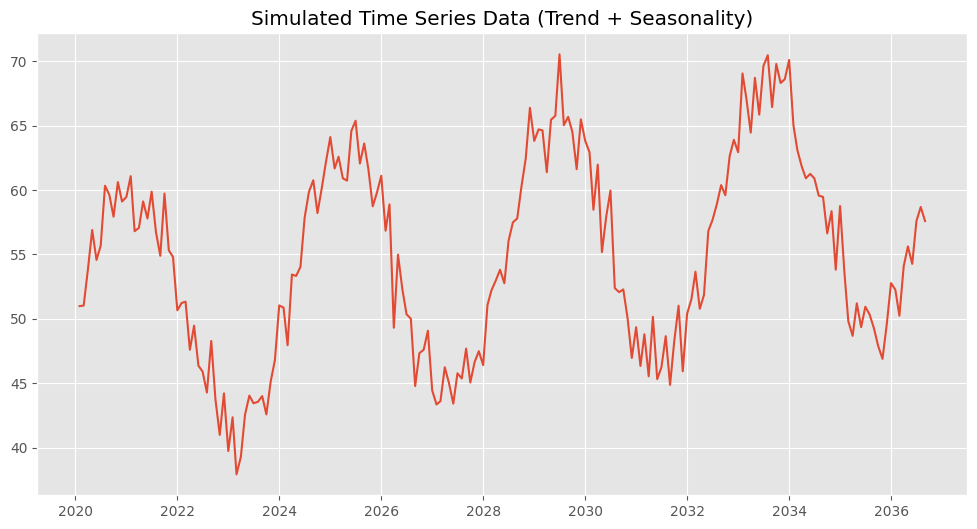

--- Augmented Dickey-Fuller Test ---
ADF Statistic: -6.1013
p-value: 0.0000
結論: 數據是平穩的 (Reject Null Hypothesis)
------------------------------------
                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  188
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -401.614
Date:                            Tue, 02 Dec 2025   AIC                            813.227
Time:                                    18:44:49   BIC                            828.634
Sample:                                01-31-2020   HQIC                           819.483
                                     - 08-31-2035                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------

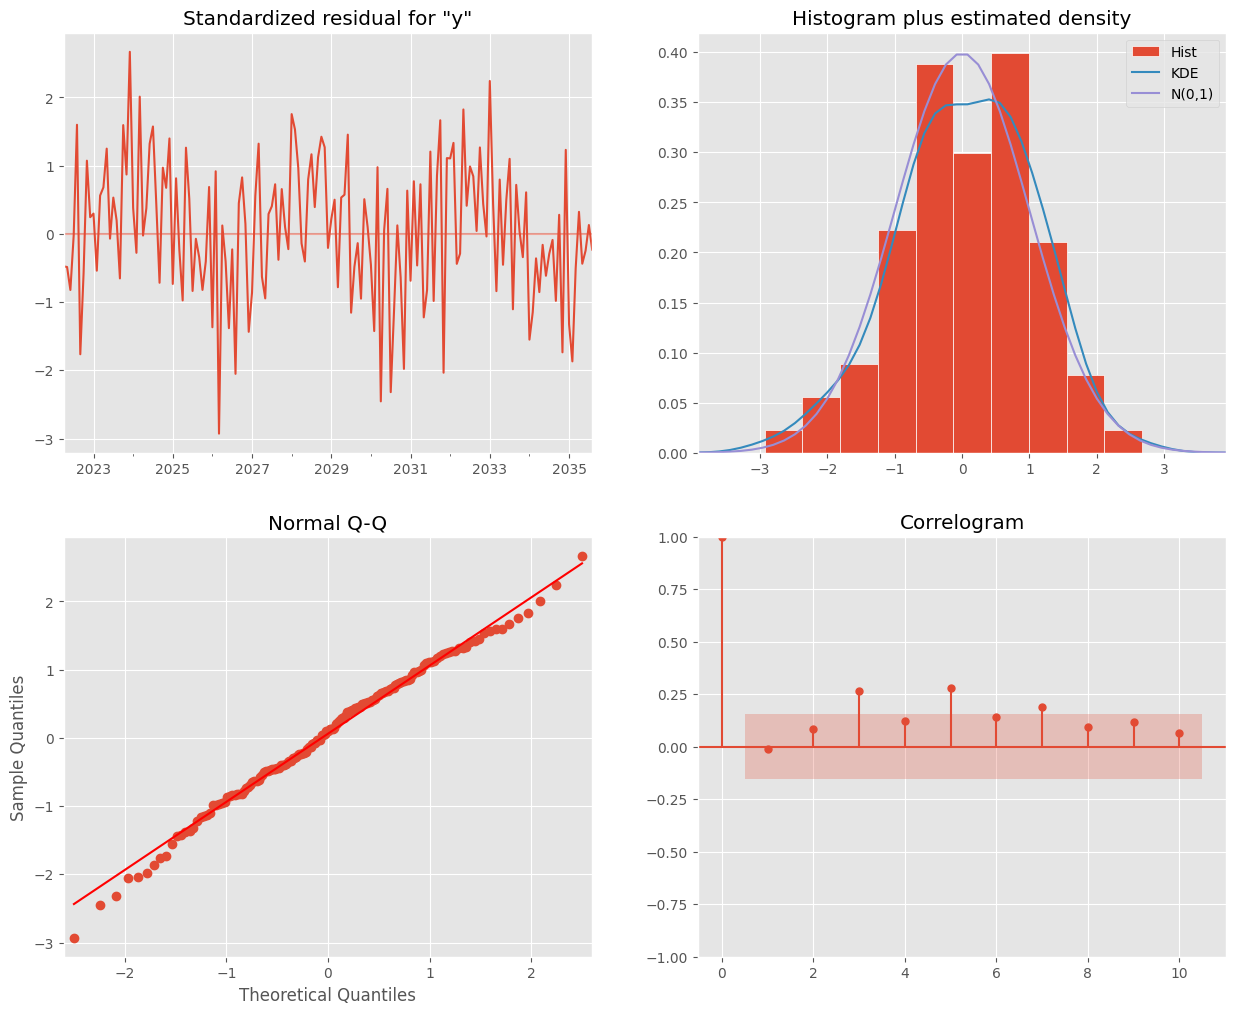


Mean Squared Error on Test Data: 24.8884


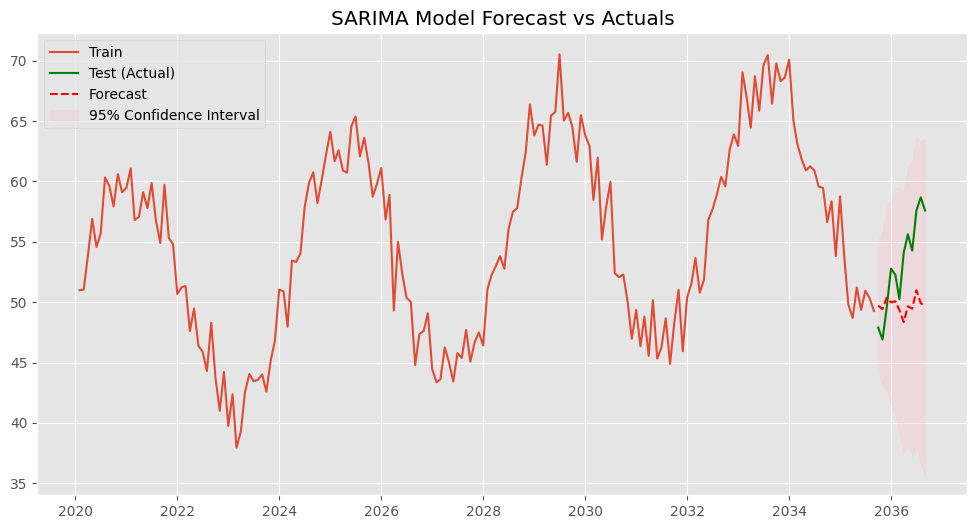

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error

# 設定繪圖風格
plt.style.use('ggplot')

# ==========================================
# 1. 生成假數據 (Synthetic Data Generation)
# ==========================================
def generate_data(n_samples=200):
    np.random.seed(42)
    # 時間索引
    dates = pd.date_range(start='2020-01-01', periods=n_samples, freq='M')

    # 線性趨勢 (Trend)
    trend = np.linspace(0, 10, n_samples)

    # 季節性 (Seasonality, 週期為 12 個月)
    seasonality = 10 * np.sin(np.linspace(0, 3.14 * 8, n_samples))

    # 雜訊 (Noise)
    noise = np.random.normal(0, 2, n_samples)

    # 合成數據
    data = trend + seasonality + noise + 50
    return pd.Series(data, index=dates)

# 生成數據
ts_data = generate_data()

# 繪製原始數據
plt.figure(figsize=(12, 6))
plt.plot(ts_data)
plt.title('Simulated Time Series Data (Trend + Seasonality)')
plt.show()

# ==========================================
# 2. 平穩性檢定 (Stationarity Check - ADF Test)
# ==========================================
def adf_check(time_series):
    result = adfuller(time_series)
    print('--- Augmented Dickey-Fuller Test ---')
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    if result[1] <= 0.05:
        print("結論: 數據是平穩的 (Reject Null Hypothesis)")
    else:
        print("結論: 數據是非平穩的 (Fail to Reject Null Hypothesis)")
    print('------------------------------------')

adf_check(ts_data)
# 注意：由於我們的數據有趨勢，通常 ADF 會顯示不平穩，這暗示我們需要進行差分 (Integration, d=1)

# ==========================================
# 3. SARIMA 建模 (Modeling)
# ==========================================
# 拆分訓練集與測試集 (最後 12 個月做測試)
train_data = ts_data[:-12]
test_data = ts_data[-12:]

# 設定 SARIMA 參數
# order=(p, d, q): 非季節性參數
# seasonal_order=(P, D, Q, s): 季節性參數 (s=12 代表年週期)
# 這裡我們手動設定參數，實際專案中可用 auto_arima 尋找最佳參數
model = SARIMAX(train_data,
                order=(1, 1, 1),
                seasonal_order=(1, 1, 1, 12),
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit(disp=False)

# 顯示模型統計摘要
print(results.summary())

# ==========================================
# 4. 模型診斷 (Diagnostics)
# ==========================================
# 檢查殘差是否為常態分佈且無相關性
results.plot_diagnostics(figsize=(15, 12))
plt.show()

# ==========================================
# 5. 預測與評估 (Forecasting & Evaluation)
# ==========================================
# 預測測試集區間
forecast_object = results.get_forecast(steps=len(test_data))
forecast = forecast_object.predicted_mean
conf_int = forecast_object.conf_int()

# 計算 MSE
mse = mean_squared_error(test_data, forecast)
print(f'\nMean Squared Error on Test Data: {mse:.4f}')

# 繪製最終結果
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data, label='Train')
plt.plot(test_data.index, test_data, label='Test (Actual)', color='green')
plt.plot(forecast.index, forecast, label='Forecast', color='red', linestyle='--')

# 繪製信賴區間 (Confidence Interval)
plt.fill_between(forecast.index,
                 conf_int.iloc[:, 0],
                 conf_int.iloc[:, 1],
                 color='pink', alpha=0.3, label='95% Confidence Interval')

plt.title('SARIMA Model Forecast vs Actuals')
plt.legend()
plt.show()